In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#how many models we want to have
total_models=11

def LDM(params,x):
    #x = (n,z)
    #params= parameters (volume, surface, asymmetry, Coulomb)
    n=x[0]
    z=x[1]

    return params[0]*(n+z) - params[1]*(n+z)**(2/3) - params[2]*((n-z)**2/(n+z)) - params[3]*((z**2)/((n+z)**(1/3)))

def LDM_quadratic_bias(params,x, a = 0.25):
    #x = (n,z)
    #params= parameters (volume, surface, asymmetry, Coulomb)
    #a = quadratic corruption coefficient
        n=x[0]
        z=x[1]
        return LDM(params,x) - a * (n+z) ** 2
    
    
LDM_truth_params=[14,13.3,0.57,17]

def Truth(x):
    return LDM(LDM_truth_params,x)

#We should create the data (paris of [N,Z])
def data_loader():
    input_NZ = pd.read_csv("NZ.txt", delim_whitespace=True, header = None)
    input_NZ.columns = ["N", "Z"]
    return input_NZ

def loading_matrix(loadings, n_features, feature_names):
    # Loadings

    # PC names
    pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]

    # Match PC names to loadings
    pc_loadings = dict(zip(pc_list, loadings))

    # Matrix of corr coefs between feature names and PCs
    loadings_df = pd.DataFrame.from_dict(pc_loadings)
    loadings_df['feature_names'] = feature_names
    loadings_df = loadings_df.set_index('feature_names')
    return loadings_df

def biplot(score,coef,labels=None):
 
    xs = score[:,0]
    ys = score[:,1]
    n = coef.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, s=5, color='orange')
 
    for i in range(n):
        plt.arrow(0, 0, coef[i,0], 
                  coef[i,1],color = 'purple',
                  alpha = 0.5)
        plt.text(coef[i,0]* 1.15, 
                 coef[i,1] * 1.15, 
                 labels[i], 
                 color = 'darkblue', 
                 ha = 'center', 
                 va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))    
    return

# Data generation

In [152]:
#Noise level we will use to "wiggle" all the model predictions a bit
corruption_noise_Mass=1000

# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()


masses_truth = Truth([input_NZ["Z"], input_NZ["N"]])
masses_distorted = LDM_quadratic_bias(LDM_truth_params,[input_NZ["Z"], input_NZ["N"]], a = 0.5)

# Model class 1: truth + noise
n_class_1 = 2
models_output = {}
for i in range(n_class_1):
    models_output["c1_" + str(i)] = masses_truth + np.random.randn(len(masses_truth)) * corruption_noise_Mass

# Model class 2: truth + quadratic distortion + noise
n_class_2 = 2
for i in range(n_class_2):
    models_output["c2_" + str(i)] = masses_distorted + np.random.randn(len(masses_truth)) * corruption_noise_Mass

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

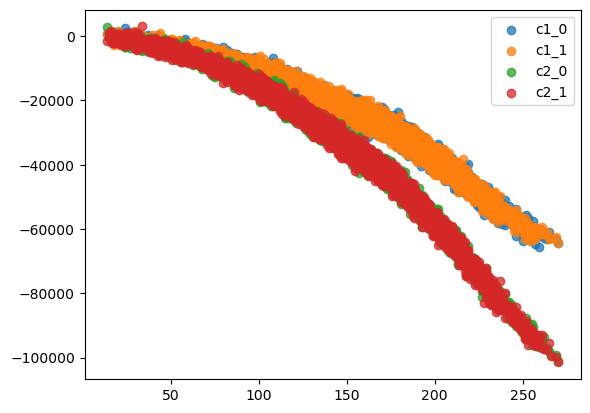

In [173]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.75)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [154]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.to_latex())

              mean           std      res_mean      res_std          rmse
c1_0 -21994.637663  16178.552902     32.361591  1000.487147   1001.010392
c1_1 -21995.497498  16164.763417     33.221426   993.920921    994.475973
c2_0 -33172.758374  24823.447037  11210.482302  8723.554033  14204.763582
c2_1 -33180.422268  24855.947587  11218.146196  8755.622354  14230.520963
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
c1_0 & -21994.637663 & 16178.552902 & 32.361591 & 1000.487147 & 1001.010392 \\
c1_1 & -21995.497498 & 16164.763417 & 33.221426 & 993.920921 & 994.475973 \\
c2_0 & -33172.758374 & 24823.447037 & 11210.482302 & 8723.554033 & 14204.763582 \\
c2_1 & -33180.422268 & 24855.947587 & 11218.146196 & 8755.622354 & 14230.520963 \\
\end{tabular}



# PCA - model output is not standardized

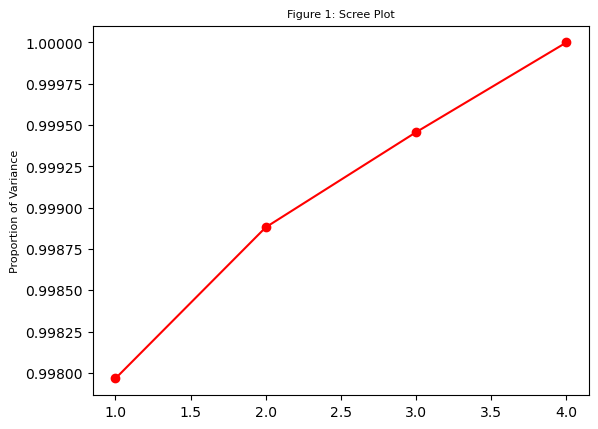

In [155]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(models_output_df[models_output.keys()])

prop_var = np.cumsum(pca.explained_variance_ratio_)
PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.savefig("Scree_Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

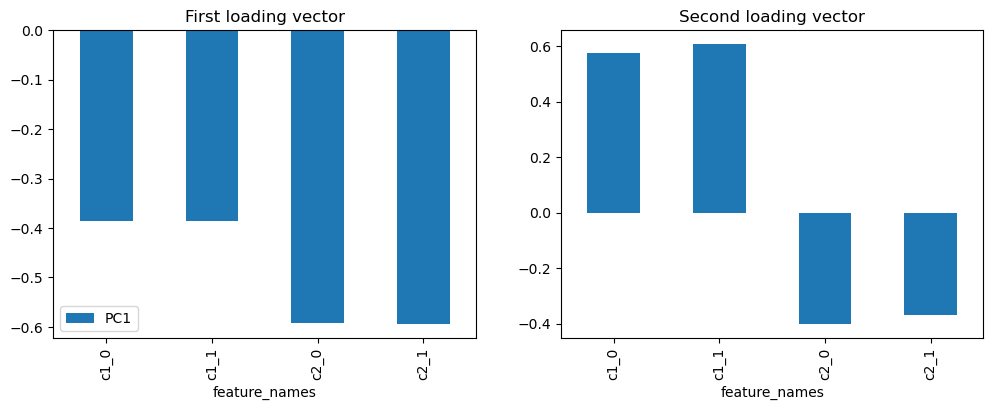

                    PC1       PC2       PC3       PC4
feature_names                                        
c1_0          -0.385594  0.577124 -0.134606  0.707196
c1_1          -0.385247  0.607902  0.101396 -0.686847
c2_0          -0.592441 -0.402463 -0.686547 -0.125261
c2_1          -0.593225 -0.367976  0.707285  0.111466


In [156]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.iloc[:, :1].plot(kind = "bar", title = "First loading vector", ax = ax1)
loadings.iloc[:, 1].plot(kind = "bar", title = "Second loading vector", ax = ax2)
plt.savefig("PC_Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

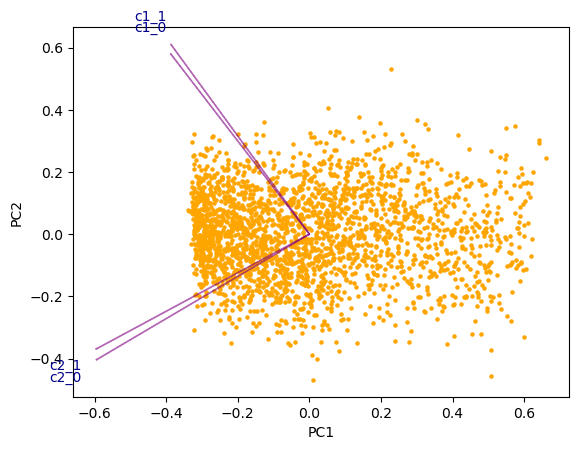

In [157]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))
plt.savefig("Biplot_Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

# PCA - model output is standardized

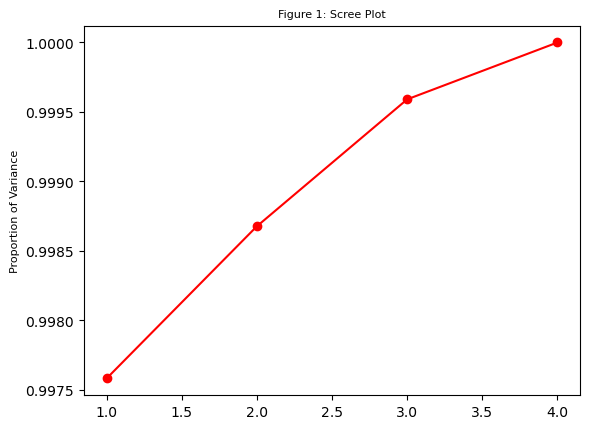

In [158]:
pca = PCA(n_components=4)
X_scaled = StandardScaler().fit_transform(models_output_df[models_output.keys()])
X_pca = pca.fit_transform(X_scaled)

prop_var = np.cumsum(pca.explained_variance_ratio_)
PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.savefig("Scree_Toy_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()

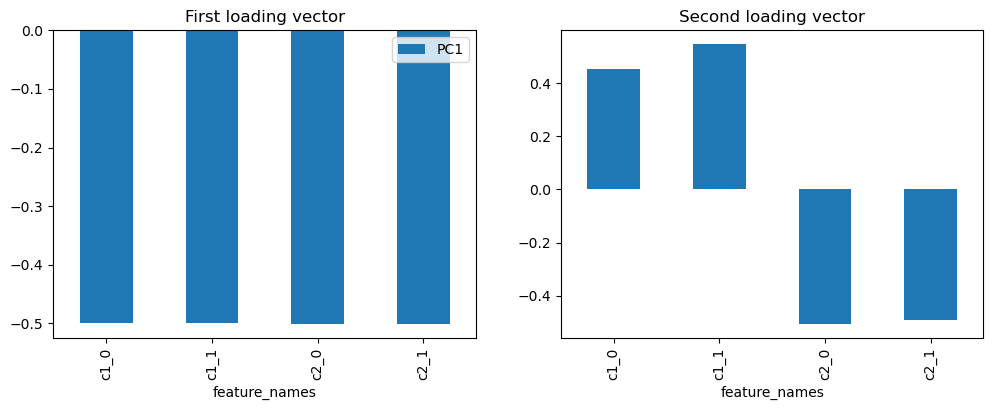

                    PC1       PC2       PC3       PC4
feature_names                                        
c1_0          -0.499882  0.451891  0.738855 -0.002518
c1_1          -0.499865  0.546067 -0.672122  0.014053
c2_0          -0.500121 -0.507409 -0.025638  0.701255
c2_1          -0.500132 -0.490042 -0.041085 -0.712768


In [159]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.iloc[:, :1].plot(kind = "bar", title = "First loading vector", ax = ax1)
loadings.iloc[:, 1].plot(kind = "bar", title = "Second loading vector", ax = ax2)
plt.savefig("PC_Toy_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

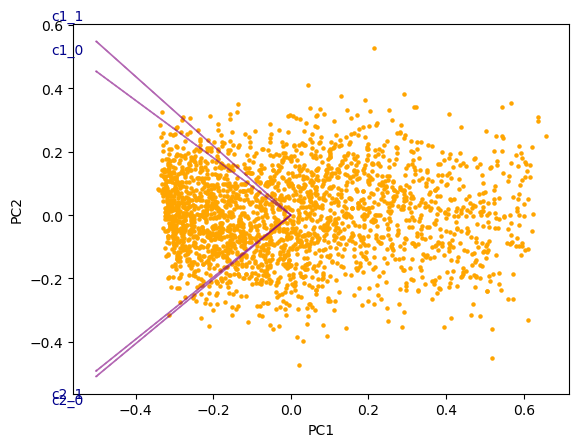

In [160]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))

plt.savefig("Biplot_Toy_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()

# PCA on residuals - residuals are not standardized

In [161]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 
np.corrcoef(residuals.T)

array([[ 1.        ,  0.03879694, -0.02305472, -0.02233265],
       [ 0.03879694,  1.        , -0.04184023, -0.03886701],
       [-0.02305472, -0.04184023,  1.        ,  0.98678195],
       [-0.02233265, -0.03886701,  0.98678195,  1.        ]])

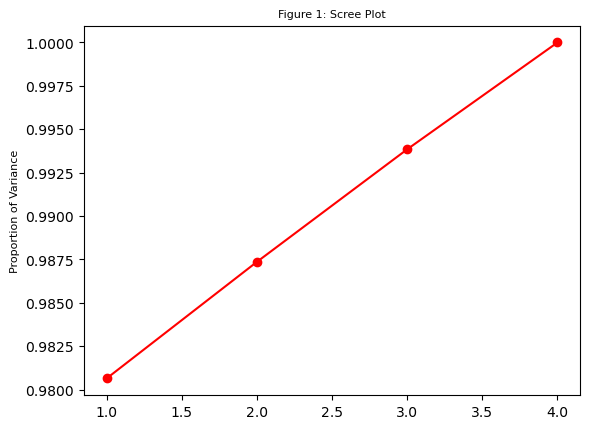

In [162]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(residuals)

prop_var = np.cumsum(pca.explained_variance_ratio_)
PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.savefig("Scree_ToyResid_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

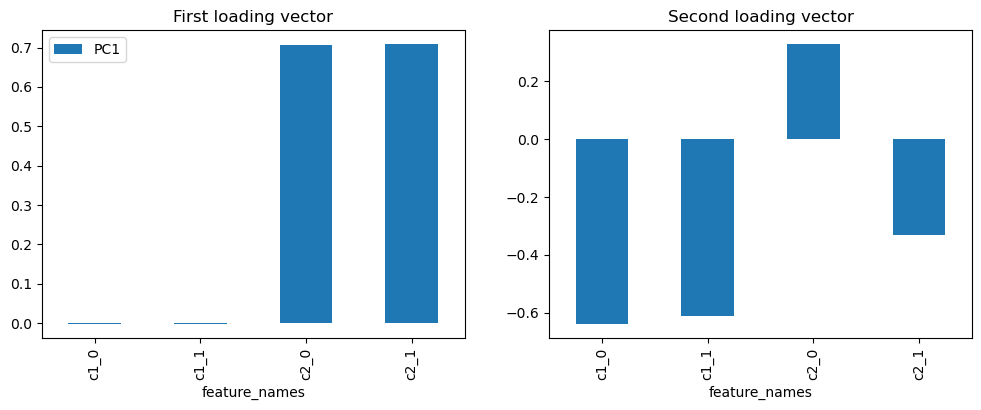

                    PC1       PC2       PC3       PC4
feature_names                                        
c1_0          -0.001862 -0.639873  0.486948  0.594508
c1_1          -0.003288 -0.610764  0.147255 -0.777993
c2_0           0.705786  0.328141  0.610880 -0.144966
c2_1           0.708415 -0.331441 -0.606649  0.142380


In [163]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.iloc[:, :1].plot(kind = "bar", title = "First loading vector", ax = ax1)
loadings.iloc[:, 1].plot(kind = "bar", title = "Second loading vector", ax = ax2)
plt.savefig("PC_ToyResid_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

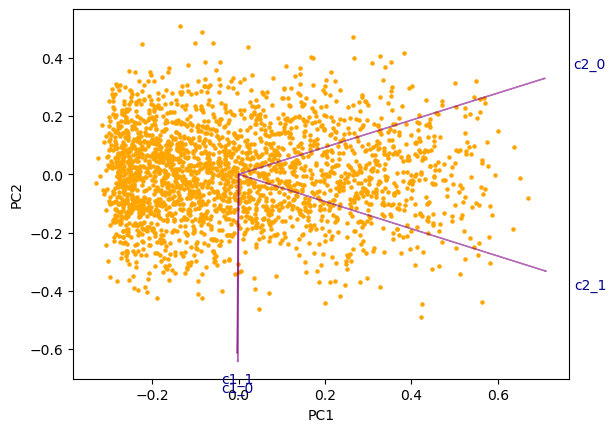

In [164]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))

plt.savefig("Biplot_ToyResid_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

# PCA on residuals - residuals are standardized

In [165]:
residuals =masses_truth.values[:,None] - models_output_df[models_output.keys()].values
np.corrcoef(residuals.T)

array([[ 1.        ,  0.03879694, -0.02305472, -0.02233265],
       [ 0.03879694,  1.        , -0.04184023, -0.03886701],
       [-0.02305472, -0.04184023,  1.        ,  0.98678195],
       [-0.02233265, -0.03886701,  0.98678195,  1.        ]])

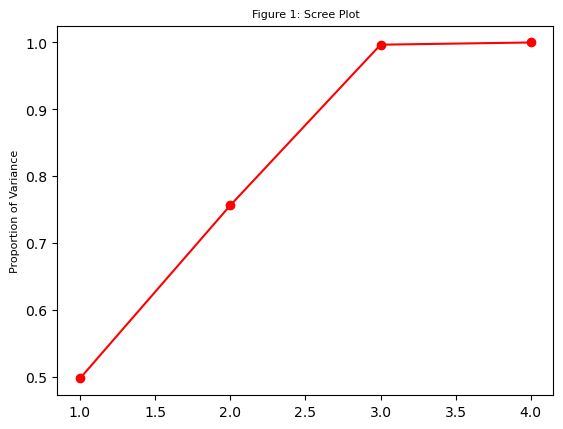

In [166]:
pca = PCA(n_components=4)
X_scaled = StandardScaler().fit_transform(residuals)
X_pca = pca.fit_transform(X_scaled)

prop_var = np.cumsum(pca.explained_variance_ratio_)
PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.savefig("Scree_ToyResid_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()

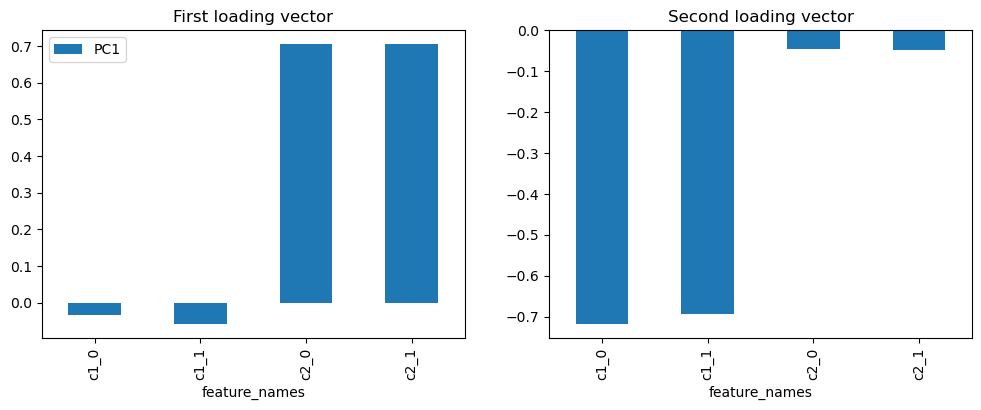

                    PC1       PC2       PC3       PC4
feature_names                                        
c1_0          -0.034602 -0.716650 -0.696574 -0.000436
c1_1          -0.058792 -0.694322  0.717256 -0.002117
c2_0           0.705510 -0.045244  0.011945 -0.707153
c2_1           0.705409 -0.047772  0.013664  0.707057


In [167]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.iloc[:, :1].plot(kind = "bar", title = "First loading vector", ax = ax1)
loadings.iloc[:, 1].plot(kind = "bar", title = "Second loading vector", ax = ax2)
plt.savefig("PC_ToyResid_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

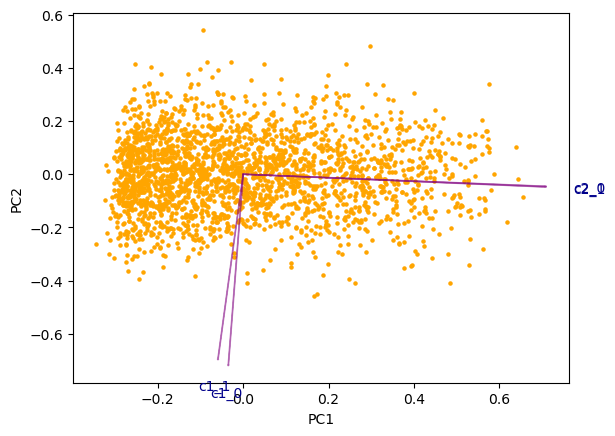

In [168]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))

plt.savefig("Biplot_ToyResid_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()